In [1]:
# copy of poduv.m
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from glob import glob
import os
import io

np.set_printoptions(linewidth=150)
np.set_printoptions(precision=3)

In [2]:
def read_vec_file(fname):
    data = np.genfromtxt(fname, skip_header=1, delimiter=',',usecols=(0,1,2,3,4))
    r,c = np.unique(data[:,1]).shape[0],np.unique(data[:,0]).shape[0] # order ?
    
    x = data[:,0].reshape(r,c)
    y = data[:,1].reshape(r,c)
    u = data[:,2].reshape(r,c)
    v = data[:,3].reshape(r,c)
    chc = data[:,4].reshape(r,c)
    return x,y,u,v,chc

In [3]:
# how to read a single file
fname = '../../small_test/06302014_2Hz_particles000200.T000.D000.P000.H000.L.vec'
X,Y,U,V,CHC = read_vec_file(fname)

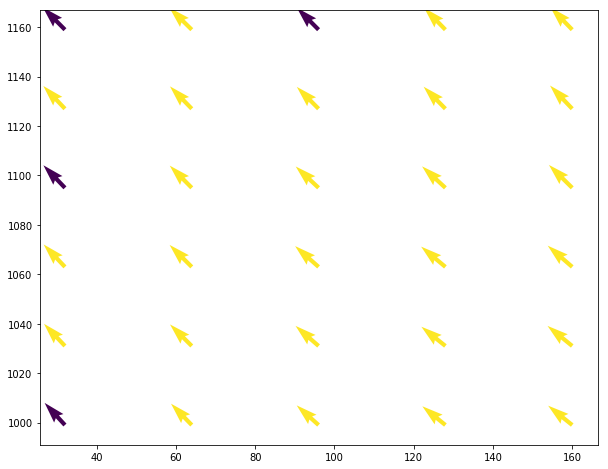

In [4]:
fig,ax = plt.subplots(figsize=(10,8))
ax.quiver(X,Y,U,V,CHC)
# ax.invert_yaxis()

In [5]:
X,Y,U,V

(array([[ 32.,  64.,  96., 128., 160.],
        [ 32.,  64.,  96., 128., 160.],
        [ 32.,  64.,  96., 128., 160.],
        [ 32.,  64.,  96., 128., 160.],
        [ 32.,  64.,  96., 128., 160.],
        [ 32.,  64.,  96., 128., 160.]]),
 array([[1159., 1159., 1159., 1159., 1159.],
        [1127., 1127., 1127., 1127., 1127.],
        [1095., 1095., 1095., 1095., 1095.],
        [1063., 1063., 1063., 1063., 1063.],
        [1031., 1031., 1031., 1031., 1031.],
        [ 999.,  999.,  999.,  999.,  999.]]),
 array([[-2.419, -2.441, -2.372, -2.314, -2.376],
        [-2.371, -2.39 , -2.384, -2.385, -2.433],
        [-2.364, -2.412, -2.507, -2.559, -2.555],
        [-2.335, -2.428, -2.572, -2.663, -2.684],
        [-2.298, -2.385, -2.524, -2.632, -2.705],
        [-2.229, -2.274, -2.399, -2.527, -2.64 ]]),
 array([[2.446, 2.406, 2.389, 2.372, 2.445],
        [2.5  , 2.454, 2.398, 2.417, 2.546],
        [2.474, 2.432, 2.339, 2.355, 2.513],
        [2.461, 2.409, 2.281, 2.223, 2.327],
    

In [6]:
list_of_vec_files = glob('../../small_test/*.vec')
list_of_vec_files.sort()
list_of_vec_files

['../../small_test/06302014_2Hz_particles000200.T000.D000.P000.H000.L.vec',
 '../../small_test/06302014_2Hz_particles000201.T000.D000.P000.H000.L.vec',
 '../../small_test/06302014_2Hz_particles000202.T000.D000.P000.H000.L.vec',
 '../../small_test/06302014_2Hz_particles000203.T000.D000.P000.H000.L.vec']

In [7]:
u,v,chc = [],[],[]
for fname in list_of_vec_files:
    X,Y,_u,_v,_chc = read_vec_file(fname)
    u.append(_u)
    v.append(_v)
    chc.append(_chc)

u = np.stack(u)
v = np.stack(v)
chc = np.stack(chc)

In [8]:
u[0,:,:]

array([[-2.419, -2.441, -2.372, -2.314, -2.376],
       [-2.371, -2.39 , -2.384, -2.385, -2.433],
       [-2.364, -2.412, -2.507, -2.559, -2.555],
       [-2.335, -2.428, -2.572, -2.663, -2.684],
       [-2.298, -2.385, -2.524, -2.632, -2.705],
       [-2.229, -2.274, -2.399, -2.527, -2.64 ]])

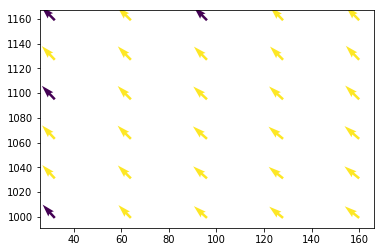

In [9]:
fig,ax = plt.subplots()
ax.quiver(X,Y,u[0,:,:],v[0,:,:],chc[0,:,:])

In [10]:
method = 'snapshot'
n_modes = None

(4, 4)


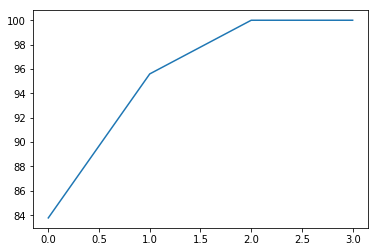

In [11]:
#def pod_modes(u,v,n_modes=None, method='snapshot'):
""" estimates POD modes of a 2D vector field using a direct or a snapshot methods """
N = len(u)
r,c = u[0].shape

# read data and rearrange in columns
len1 = r*c

U = np.zeros((len1*2,N)) # r*c*3 length of the vector

# stack [u,v] together in columns
for i in range(N):
    U[:len1,i] = u[i,:,:].flatten()
    U[len1:,i] = v[i,:,:].flatten()

# fluctuations
Umean = np.mean(U,axis=1)
Uf = U - Umean[:,np.newaxis]

if method is 'snapshot': # small size as number of snapshots
    R = np.dot(Uf.T,Uf)  # R = Uf.T@Uf equivalent expression
elif method is 'direct': # large size as size of the PIV map
    R = np.dot(Uf,Uf.T)  # or R  = Uf@Uf.T

print(R.shape)

D,V = np.linalg.eig(R)

# check consistency 
assert (np.abs(np.dot(R,V) - np.dot(V,np.diag(D))).max() < 1e-11)

_ = D/N
L = np.sort(_)
I = np.argsort(_)

L = L[::-1]
I = I[::-1]

Erel = np.cumsum(L/np.sum(L))
plt.figure()
plt.plot(Erel[:N]*100)

# modes
if n_modes is None:
    n_modes = len(D) # all modes, otherwise change the number of modes
if method is 'snapshot':
    S = np.sqrt(np.abs(D))
    S = S[I]
    V = V[:,I]
    a = np.diag(S[:n_modes])@V[:,:n_modes].T
    phi = Uf@V[:,:n_modes]@np.diag(1./S[:n_modes])
elif method is 'direct':
    phi = V[:,I]
    a = np.dot(Uf.T,phi[:,:n_modes]).T
    phi = np.real(phi[:,:n_modes])

umodes,vmodes = np.zeros((r,c,n_modes)),np.zeros((r,c,n_modes))
for i in range(n_modes):
    umodes[:,:,i] = phi[:len1,i].reshape(r,c)
    vmodes[:,:,i] = phi[len1:,i].reshape(r,c)
    # return umodes,vmodes

In [12]:
U

array([[-2.419, -1.271, -1.203, -2.563],
       [-2.441, -1.967, -1.892, -2.603],
       [-2.372, -2.364, -2.287, -2.686],
       [-2.314, -2.489, -2.378, -2.686],
       [-2.376, -2.524, -2.421, -2.526],
       [-2.371, -1.962, -1.874, -2.526],
       [-2.39 , -2.273, -2.189, -2.542],
       [-2.384, -2.494, -2.419, -2.628],
       [-2.385, -2.623, -2.484, -2.671],
       [-2.433, -2.644, -2.503, -2.61 ],
       [-2.364, -2.369, -2.252, -2.49 ],
       [-2.412, -2.508, -2.383, -2.489],
       [-2.507, -2.64 , -2.562, -2.564],
       [-2.559, -2.715, -2.646, -2.643],
       [-2.555, -2.721, -2.639, -2.664],
       [-2.335, -2.458, -2.346, -2.446],
       [-2.428, -2.519, -2.401, -2.446],
       [-2.572, -2.613, -2.553, -2.513],
       [-2.663, -2.684, -2.658, -2.61 ],
       [-2.684, -2.729, -2.672, -2.685],
       [-2.298, -2.415, -2.339, -2.402],
       [-2.385, -2.416, -2.332, -2.4  ],
       [-2.524, -2.533, -2.426, -2.464],
       [-2.632, -2.651, -2.558, -2.566],
       [-2.705, 

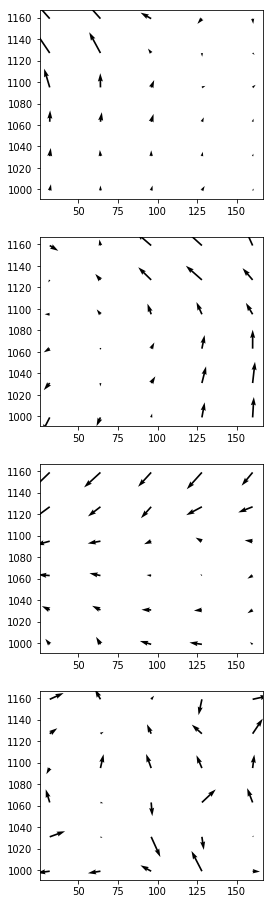

In [56]:
fig,ax = plt.subplots(4,1,figsize=(4,16))
for i in range(n_modes):
    ax[i].quiver(X,Y,umodes[:,:,i],vmodes[:,:,i])

In [14]:
# umd,vmd = pod_modes(u,v,method='direct')
# ums,vms = pod_modes(u,v,method='snapshot')

In [15]:
S

array([2.482e+00, 9.322e-01, 5.691e-01, 1.306e-08])

In [16]:
tmp = [2.4818, 0.9322, 0.5691, 0.0000]

In [17]:
tmp

[2.4818, 0.9322, 0.5691, 0.0]

In [31]:
assert np.abs(tmp - S).max() < .2e-4 # why is it so inaccurate? 

In [32]:
V

array([[ 0.386, -0.775, -0.027, -0.5  ],
       [-0.569,  0.017,  0.652, -0.5  ],
       [-0.413,  0.143, -0.748, -0.5  ],
       [ 0.597,  0.615,  0.122, -0.5  ]])

In [33]:
_="""     0.3856   -0.7750    0.0267   -0.5000
   -0.5693    0.0169   -0.6524   -0.5000
   -0.4133    0.1427    0.7475   -0.5000
    0.5970    0.6154   -0.1218   -0.5000 """
V_mat = np.genfromtxt(io.BytesIO(_.encode()))

In [35]:
V - (V_mat)

array([[-3.348e-05, -1.455e-06, -5.337e-02,  0.000e+00],
       [ 2.362e-05,  1.264e-05,  1.305e+00, -6.661e-16],
       [-1.246e-05, -2.118e-05, -1.495e+00,  8.327e-16],
       [ 2.233e-05,  9.996e-06,  2.436e-01, -1.110e-16]])

In [22]:
_ = """0.9569   -1.4128   -1.0258    1.4817
   -0.7225    0.0158    0.1330    0.5737
    0.0152   -0.3713    0.4254   -0.0693
   -0.0000   -0.0000   -0.0000   -0.0000
 """
a_mat = np.genfromtxt(io.BytesIO(_.encode()))

In [40]:
a

array([[ 9.569e-01, -1.413e+00, -1.026e+00,  1.482e+00],
       [-7.225e-01,  1.577e-02,  1.330e-01,  5.737e-01],
       [-1.518e-02,  3.713e-01, -4.254e-01,  6.932e-02],
       [-6.532e-09, -6.532e-09, -6.532e-09, -6.532e-09]])

In [45]:
phi

array([[-5.005e-01,  1.119e-01, -3.132e-01,  3.505e-08],
       [-2.392e-01, -1.388e-02, -2.123e-01, -1.381e-08],
       [-9.149e-02, -1.936e-01, -1.700e-01,  7.436e-09],
       [-3.879e-02, -2.583e-01, -1.963e-01, -8.498e-09],
       [ 5.289e-03, -1.086e-01, -1.430e-01,  4.037e-08],
       [-2.139e-01, -1.879e-02, -2.164e-01,  1.912e-08],
       [-9.689e-02, -6.752e-02, -1.622e-01,  7.967e-09],
       [-2.757e-02, -1.681e-01, -1.328e-01, -1.062e-08],
       [ 2.385e-03, -2.085e-01, -2.032e-01, -2.549e-08],
       [ 1.739e-02, -1.311e-01, -1.869e-01,  2.549e-08],
       [-4.800e-02, -6.607e-02, -1.791e-01, -8.498e-09],
       [-1.442e-03, -4.846e-02, -1.656e-01,  7.967e-09],
       [ 2.591e-02, -4.843e-02, -9.225e-02, -1.275e-08],
       [ 2.999e-02, -7.105e-02, -8.197e-02, -1.381e-08],
       [ 2.563e-02, -8.775e-02, -1.036e-01,  4.249e-09],
       [ 3.322e-03, -7.759e-02, -1.505e-01, -1.009e-08],
       [ 1.191e-02, -9.687e-03, -1.430e-01,  6.905e-09],
       [ 2.061e-02,  4.135e-02,

In [47]:
_="""    -0.5005    0.1119    0.3132    0.0000
   -0.2139   -0.0188    0.2164    0.0000
   -0.0480   -0.0661    0.1791   -0.0000
    0.0033   -0.0776    0.1505   -0.0000
    0.0089   -0.0772    0.1021    0.0000
    0.0109   -0.1006    0.0572   -0.0000
   -0.2392   -0.0139    0.2123   -0.0000
   -0.0969   -0.0675    0.1622    0.0000
   -0.0014   -0.0485    0.1656    0.0000
    0.0119   -0.0097    0.1430    0.0000
   -0.0053   -0.0025    0.1080    0.0000
   -0.0000   -0.0514    0.0567   -0.0000
   -0.0915   -0.1936    0.1700    0.0000
   -0.0276   -0.1681    0.1328   -0.0000
    0.0259   -0.0484    0.0923   -0.0000
    0.0206    0.0413    0.0596   -0.0000
    0.0003    0.0544    0.1259    0.0000
    0.0118    0.0122    0.1465   -0.0000
   -0.0388   -0.2583    0.1963   -0.0000
    0.0024   -0.2085    0.2032   -0.0000
    0.0300   -0.0710    0.0820   -0.0000
    0.0167    0.0352    0.0193    0.0000
    0.0078    0.0543    0.1039   -0.0000
    0.0240    0.0359    0.1618   -0.0000
    0.0053   -0.1086    0.1430    0.0000
    0.0174   -0.1311    0.1869    0.0000
    0.0256   -0.0877    0.1036    0.0000
    0.0079    0.0007    0.0674   -0.0000
    0.0060    0.0308    0.0667   -0.0000
    0.0100    0.0157    0.0357    0.0000
    0.5630   -0.0689    0.3027    0.0000
    0.3174   -0.0331    0.1595    0.0000
    0.1610    0.0010    0.0486   -0.0000
    0.0984   -0.0475   -0.0113    0.0000
    0.0703   -0.0925   -0.0499    0.0000
    0.0542   -0.1965   -0.0712    0.0000
    0.2660    0.0787    0.1944    0.0000
    0.1792    0.0779    0.1245   -0.0000
    0.1224    0.0637    0.0296    0.0000
    0.0825   -0.0107   -0.0304    0.0000
    0.0534   -0.0445   -0.0534    0.0000
    0.0432   -0.1141   -0.0971    0.0000
    0.0515    0.1673    0.1862   -0.0000
    0.0383    0.1647    0.1480    0.0000
    0.0631    0.1385    0.0390    0.0000
    0.0680    0.0810   -0.0070   -0.0000
    0.0502    0.0871   -0.0031   -0.0000
    0.0430    0.0500   -0.0432    0.0000
   -0.0452    0.2344    0.2182   -0.0000
   -0.0318    0.1840    0.1083    0.0000
    0.0129    0.1590   -0.0466    0.0000
    0.0382    0.1766   -0.0200    0.0000
    0.0377    0.2168    0.0092   -0.0000
    0.0391    0.1963   -0.0234    0.0000
   -0.0454    0.2414    0.1722   -0.0000
   -0.0152    0.1531    0.0731    0.0000
    0.0222    0.1488   -0.0108    0.0000
    0.0265    0.2463    0.0398    0.0000
    0.0215    0.2761    0.0425   -0.0000
    0.0170    0.2649   -0.0281   -0.0000
    """
phi_mat = np.genfromtxt(io.BytesIO(_.encode()))

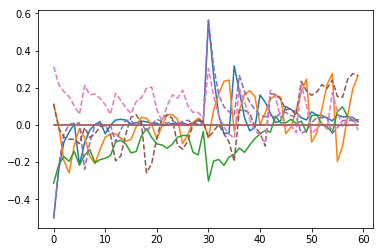

In [49]:
plt.figure()
plt.plot(phi)
plt.plot(phi_mat,'--')

In [ ]:
u[0,:,:]

In [ ]:
Uf[:,0]

In [ ]:
umodes[:,:,0]

In [ ]:
_="""-0.5005   -0.2392   -0.0915   -0.0388    0.0053
   -0.2139   -0.0969   -0.0276    0.0024    0.0174
   -0.0480   -0.0014    0.0259    0.0300    0.0256
    0.0033    0.0119    0.0206    0.0167    0.0079
    0.0089   -0.0053    0.0003    0.0078    0.0060
    0.0109   -0.0000    0.0118    0.0240    0.0100"""
umodes_mat = np.genfromtxt(io.BytesIO(_.encode()))

In [ ]:
umodes_mat

In [43]:
u[0,:,:]

array([[-2.419, -2.441, -2.372, -2.314, -2.376],
       [-2.371, -2.39 , -2.384, -2.385, -2.433],
       [-2.364, -2.412, -2.507, -2.559, -2.555],
       [-2.335, -2.428, -2.572, -2.663, -2.684],
       [-2.298, -2.385, -2.524, -2.632, -2.705],
       [-2.229, -2.274, -2.399, -2.527, -2.64 ]])

In [44]:
Uf

array([[-5.550e-01,  5.926e-01,  6.615e-01, -6.991e-01],
       [-2.157e-01,  2.590e-01,  3.339e-01, -3.772e-01],
       [ 5.487e-02,  6.309e-02,  1.404e-01, -2.584e-01],
       [ 1.525e-01, -2.216e-02,  8.896e-02, -2.193e-01],
       [ 8.567e-02, -6.226e-02,  4.095e-02, -6.436e-02],
       [-1.879e-01,  2.216e-01,  3.090e-01, -3.428e-01],
       [-4.148e-02,  7.562e-02,  1.594e-01, -1.935e-01],
       [ 9.708e-02, -1.302e-02,  6.244e-02, -1.465e-01],
       [ 1.560e-01, -8.212e-02,  5.629e-02, -1.302e-01],
       [ 1.142e-01, -9.603e-02,  4.423e-02, -6.236e-02],
       [ 4.525e-03,  2.580e-04,  1.167e-01, -1.214e-01],
       [ 3.615e-02, -6.022e-02,  6.549e-02, -4.142e-02],
       [ 6.119e-02, -7.163e-02,  6.225e-03,  4.220e-03],
       [ 8.127e-02, -7.393e-02, -5.341e-03, -2.003e-03],
       [ 8.949e-02, -7.606e-02,  6.113e-03, -1.955e-02],
       [ 6.152e-02, -6.180e-02,  5.031e-02, -5.003e-02],
       [ 2.056e-02, -7.006e-02,  4.732e-02,  2.175e-03],
       [-9.248e-03, -5.060e-02,